In [28]:
import numpy as np
import sys
sys.path.append("../")
from data_loader import KeypointsDataset, KeypointsDataModule

In [29]:
	
class HeatmapGenerator():
    def __init__(self, output_res, num_joints, sigma=-1):
        self.output_res = output_res
        self.num_joints = num_joints
        if sigma < 0:
            sigma = self.output_res/64
        self.sigma = sigma
        size = 6*sigma + 3
        x = np.arange(0, size, 1, float)
        y = x[:, np.newaxis]
        x0, y0 = 3*sigma + 1, 3*sigma + 1
        self.g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    def __call__(self, joints):
        hms = np.zeros((self.num_joints, self.output_res, self.output_res),
                       dtype=np.float32)
        sigma = self.sigma
        for p in joints:
            for idx, pt in enumerate(p):
                print(pt)
                if pt[2] > 0:
                    x, y = int(pt[0]), int(pt[1])
                    if x < 0 or y < 0 or \
                       x >= self.output_res or y >= self.output_res:
                        continue

                    ul = int(np.round(x - 3 * sigma - 1)), int(np.round(y - 3 * sigma - 1))
                    br = int(np.round(x + 3 * sigma + 2)), int(np.round(y + 3 * sigma + 2))

                    c, d = max(0, -ul[0]), min(br[0], self.output_res) - ul[0]
                    a, b = max(0, -ul[1]), min(br[1], self.output_res) - ul[1]

                    cc, dd = max(0, ul[0]), min(br[0], self.output_res)
                    aa, bb = max(0, ul[1]), min(br[1], self.output_res)
                    hms[idx, aa:bb, cc:dd] = np.maximum(
                        hms[idx, aa:bb, cc:dd], self.g[a:b, c:d])
        return hms

In [30]:
data_dirs=["/mnt/vol_b/training_data/clean/0004-bare-feet/source/v001"]
input_size=(480, 480)
dm = KeypointsDataModule(data_dirs, input_size)
# ds = KeypointsDataset(data_path=Path("/mnt/vol_b/clean_data/tmp2"))
dm.setup("fit")
dl = dm.train_dataloader()



In [34]:
image, target = next(iter(dl))

In [32]:

h=HeatmapGenerator(480, 1)

In [59]:
from torch.nn import MSELoss
criterion = MSELoss(reduction="sum")
criterion(target[0][0], target[0][0])


tensor(0.)

In [55]:
from torch import nn
import torch
class HeatmapLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, gt, mask=None, scale=1.0):
        assert pred.size() == gt.size()

        dis = gt.clone()
        dis = torch.where(torch.gt(gt, 0), gt, gt + 1)
        dis = torch.log(dis)

        scaled_gt = gt + gt*dis*scale + 0.5*gt*dis**2*scale**2
        weight = torch.abs(1-pred) * gt ** 0.01 + torch.abs(pred) * (1 - gt**0.01)

        loss = (pred - scaled_gt)**2 * weight  #* mask[:,None].expand_as(gt)
        print(loss.shape)
        loss = loss.mean()

        return loss

In [58]:
# %%debug
hmloss = HeatmapLoss()
hmloss(target[0][0], target[0][0])

torch.Size([12, 480, 480])


tensor(20806.4082)

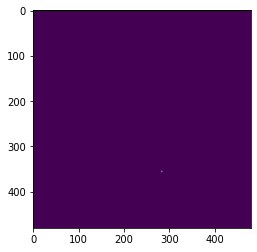

In [40]:
plt.imshow(target[0][0][0].numpy())

In [19]:
points = np.array([[[1.0,2., 1]]])
g=h(points)

[1. 2. 1.]


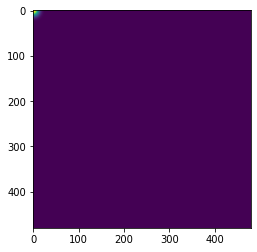

In [20]:
import matplotlib.pyplot as plt
plt.imshow(g[0,:,:])